# Results Section: Comparisons

Colors:<br>
https://matplotlib.org/examples/color/named_colors.html

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path

import sklearn
import numpy as np
import pandas as pd
from scipy.stats import iqr
from glob import glob

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

# Make all python scripts available in the path
sys.path.append('../')

import pp_utils
import lrn_crv_plot
%matplotlib inline

filepath = Path(os.getcwd())
print(filepath)

/vol/ml/apartin/projects/LearningCurves/notebooks


In [3]:
from fit import * # weighted_power_law, fit_weighted_pwr_law
import rpy2.robjects as robjects

In [4]:
save_fig_path = filepath/'figs/compare'
os.makedirs(save_fig_path, exist_ok=True)

def save_fig(save_fig_path, fname):    
    # plt.savefig(save_fig_path/(fname + '.eps'), format='eps')
    plt.savefig(save_fig_path/(fname + '.png'), dpi=200)

In [5]:
def calc_gof(y, yfit):
    gof = {}
    rmse = sqrt( metrics.mean_squared_error(y, yfit) )
    mae = metrics.mean_absolute_error(y, yfit)
    gof['rmse'] = rmse
    gof['mae'] = mae
    return gof

In [6]:
def avg_runs(base_dir):
    runs = glob(str(base_dir/'*'))
    scores = []
    prf = 'id'
    for i, r in enumerate(runs):
        # scr_tmp = pd.read_csv( Path(r)/'lrn_crv_scores.csv' )
        dpath = Path(r)/'lrn_crv_scores.csv'
        if not dpath.exists():
            continue

        scr_tmp = pd.read_csv( dpath )
        scr_tmp.rename(columns={'fold0': prf+str(i)}, inplace=True)
        if len(scores)==0:
            scores = scr_tmp
        else:
            scores = scores.merge(scr_tmp, on=['metric', 'tr_size', 'set'])

    run_col_names = [c for c in scores.columns if prf in c]

    scores_mean   = scores[run_col_names].mean(axis=1)
    scores_median = scores[run_col_names].median(axis=1)
    scores_std    = scores[run_col_names].std(axis=1)
    # scores_iqr    = iqr(scores.iloc[:, 6:].values, axis=0)

    scores.insert(loc=3, column='mean', value=scores_mean)
    scores.insert(loc=3, column='median', value=scores_median)
    scores.insert(loc=3, column='std', value=scores_std)
    print(len(np.unique(scores.tr_size)))

    # display(scores[:2])
    print('Training set sizes:', np.unique(scores.tr_size))

    # scores_te = scores[(scores.metric=='mean_absolute_error') & (scores.set=='te')].reset_index(drop=True).iloc[:, :6]
    scores_te = scores[(scores.metric=='mean_absolute_error') & (scores.set=='te')].reset_index(drop=True)

    save = True
    if save:
        scores.to_csv(base_dir/'all_seed_runs_scores.csv', index=False)
        scores_te.to_csv(base_dir/'scores.csv', index=False)
        
    return scores_te

# Load GDSC results
There are a number of runs with GDSC.<br>
Need to choose the best!

#### GBDT: good data!

In [6]:
lgb_gdsc = avg_runs(base_dir=Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/multi_seed_lgbm_100_trees'))

17
Training set sizes: [    2     4     8    16    32    64   128   256   512  1024  2048  4096
  8192 16384 32768 65536 88416]


#### NN: need to choose the best!

In [7]:
# From a few recent runs

# nn_gdsc = avg_runs(base_dir=Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/nn_reg_ls_best'))

**Final nn_reg run**

In [ ]:
path = pd.read_csv(Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/nn_reg_final/lrn_crv_scores.csv'))

**Run with 2nd best HPs --> good enough**

In [8]:
# nn_gdsc = pd.read_csv(Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/gdsc.adam.nn_reg0.ge.dd.auc_2019-11-20_ls_best_run1/lrn_crv_scores.csv'))
# nn_gdsc = nn_gdsc[(nn_gdsc.metric=='mean_absolute_error') & (nn_gdsc.set=='te')].sort_values('tr_size').reset_index(drop=True)
# nn_gdsc = nn_gdsc.rename(columns={'fold0': 'mean_absolute_error'})

**Run intergrated from 2nd best HPs and best of 16384 --> the best**

In [9]:
nn_gdsc = pd.read_csv(Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/hack_nn_reg0_ls_best/lrn_crv_scores.csv'))
# nn_gdsc = nn_gdsc[(nn_gdsc.metric=='mean_absolute_error') & (nn_gdsc.set=='te')].sort_values('tr_size').reset_index(drop=True)
# nn_gdsc = nn_gdsc.rename(columns={'fold0': 'mean_absolute_error'})

nn_gdsc = nn_gdsc[(nn_gdsc.metric=='mean_absolute_error') & (nn_gdsc.set=='te')].sort_values('tr_size').reset_index(drop=True)
nn_gdsc = nn_gdsc.rename(columns={'fold0': 'mean_absolute_error'})

**Data from HPO run on Summit**

In [10]:
# def top_n_runs(df, tr_size=None, n=10, sort_by_metric='mean_absolute_error', plot=False):
#     """ Return top runs based on sort_by_metric. """
#     if tr_size is not None:
#         df = df[df['tr_size']==tr_size].reset_index(drop=True)
#     if sort_by_metric == 'r2':
#         df = df.sort_values(sort_by_metric, ascending=False).iloc[:n, :]
#     else:
#         df = df.sort_values(sort_by_metric, ascending=True).iloc[:n, :]
    
#     if plot: display(df.transpose())
#     return df.reset_index(drop=True)

# def my_lambda(df_row, hps_dct):
#     """ Return True if a run used hps that appear in hps_dct. """
#     cols = list( set(df_row.index).intersection(hps_dct.keys()) )
#     return np.array( [df_row[c]==hps_dct[c] for c in cols] ).all()

# def extract_runs_by_specific_hps(hp_df, hps_dct):
#     """ Take df where each row contains parameters of a single run, and extract all runs (rows)
#     that share the same parameters specified by hps_dct.
#     """
#     hp_df = hp_df[ hp_df.apply(lambda df_row: my_lambda(df_row, hps_dct), axis=1 ) ].sort_values('tr_size').reset_index(drop=True)
#     return hp_df

# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/hpo_runs/lc_gdsc_nn_reg0_hpo')
# hp = pd.read_csv( base_dir/'hpo_all.csv' )

# common_cols = ['tr_size', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'r2', 'run_id']
# col_subset = ['batch_size', 'lr', 'opt', 'dr_rate', 'batchnorm', # HPs
#                   'epoch_stop', 'epochs']
# col_subset = col_subset + common_cols

# common_cols = ['tr_size', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'r2', 'run_id']
# hp = hp[[c for c in col_subset if c in hp.columns]]
# print('hp dataframe:', hp.shape)

# best = top_n_runs(hp, tr_size=hp['tr_size'].max(), n=1, sort_by_metric='mean_absolute_error', plot=False)
# display(best)

# prm_names = ['dr_rate', 'opt', 'lr', 'batchnorm', 'batch_size']
# dflt_hp_dct = {'batch_size': 32, 'batchnorm': True, 'dr_rate': 0.2, 'lr': 0.0001, 'opt': 'sgd'}

# hp_cols = [c for c in dflt_hp_dct.keys()]
# ls_hp_best_dct = {c: best[c].values[0] for c in hp_cols}
# ls_best = extract_runs_by_specific_hps(hp, ls_hp_best_dct) # hp_ls_best

# nn_gdsc = ls_best.copy()

## GDSC (GBDT vs NN)

In [11]:
figsize = (6, 4.5)
metric_name = 'mean_absolute_error'
tr_set = 'te'

plot_args = {'metric_name': metric_name, 'xtick_scale': 'log2', 'ytick_scale': 'linear', 'figsize': figsize}

In [12]:
# The previous two figures should help decide which shards to use
# lgb_shift_idx = 0
lgb_shift_idx = 7
# lgb_shift_idx = 9
lgb = lgb_gdsc[lgb_shift_idx:].reset_index(drop=True)

# nn_shift_idx = 0
nn_shift_idx = 1
# nn_shift_idx = 3
nn = nn_gdsc[nn_shift_idx:].reset_index(drop=True)

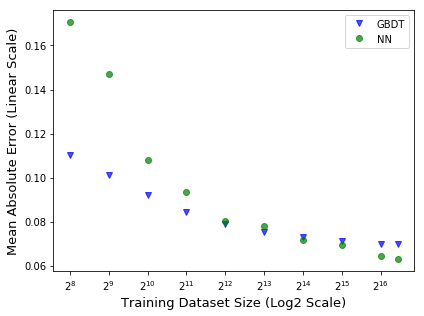

In [13]:
x = lgb['tr_size'] #[3:]
y = lgb['median']  #[3:]
ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, # yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=0.7,
                                   **plot_args, color='b', label='GBDT')
x = nn['tr_size']  #[3:]
y = nn['mean_absolute_error']  #[3:]
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, # yerr=yerr,
                                   ax=ax, ls='', marker='o', alpha=0.7,
                                   **plot_args, color='g', label='NN')

ax.legend(frameon=True, fontsize=10, loc='best')
plt.tight_layout()
ax.grid(False)

{'alpha': 0.7226889856789331, 'beta': -0.49304481962168745, 'gamma': 0.06699775545074088}
{'alpha': 1.4955657230488897, 'beta': -0.47667832722653536, 'gamma': 0.05691839523310707}


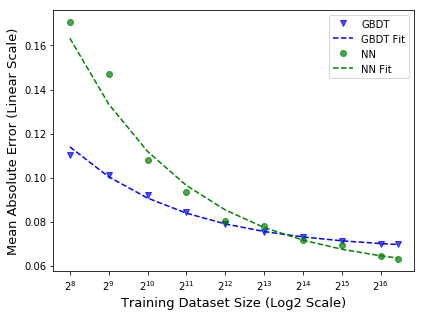

In [14]:
ax = None

x = lgb['tr_size']
y = lgb['median']

shard_min_idx = 0
xf = x[shard_min_idx:]
yf = y[shard_min_idx:]
prms_lgb = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms_lgb)

ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, # yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=0.7,
                                   **plot_args, color='b', label='GBDT')

ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=1,
                                   **plot_args, color='b', label='GBDT Fit')

x = nn['tr_size']
# y = nn['median']
y = nn['mean_absolute_error']

shard_min_idx = 0
xf = x[shard_min_idx:]
yf = y[shard_min_idx:]
prms_nn = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms_nn)

ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, # yerr=yerr,
                                   ax=ax, ls='', marker='o', alpha=0.7,
                                   **plot_args, color='g', label='NN')

ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=1,
                                   **plot_args, color='g', label='NN Fit')

ax.legend(frameon=True, fontsize=10, loc='best');
plt.tight_layout()
# ax.set_xlim([2**2, 2**17])
# ax.set_ylim([2**-4, 2**-2])
# ax.set_xlim([2**2, 2**17])
# ax.set_ylim([0.055, 0.165])
# ax.set_ylim([0.065, 0.165])
ax.grid(False)
# ax.set_xticks([2**i for i in range(2, 17)]) # GDSC
# ax.set_xticks([2**i for i in range(2, 19)]) # Top6
save_fig(save_fig_path, fname='gbdt_vs_nn_on_gdsc')

print(prms_lgb)
print(prms_nn)

# Load Top6

In [7]:
lgb_top6 = avg_runs(base_dir=Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/multi_seed_lgbm_100_trees'))

18
Training set sizes: [     2      4      8     16     32     64    128    256    512   1024
   2048   4096   8192  16384  32768  65536 131072 213015]


**Single run with best HPs**

In [15]:
# nn_top6 = pd.read_csv(Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/top6.adam.nn_reg0.ge.dd.auc_2019-11-23_ls_best/lrn_crv_scores.csv'))
# # nn_top6 = pd.read_csv(Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/nn_reg0/run_02/lrn_crv_scores.csv'))
# nn_top6 = nn_top6[(nn_top6.metric=='mean_absolute_error') & (nn_top6.set=='te')].sort_values('tr_size').reset_index(drop=True)
# nn_top6 = nn_top6.rename(columns={'fold0': 'mean_absolute_error'})

**Multi-run with best HPs --> BEST!**

In [19]:
nn_top6 = pd.read_csv(Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/nn_reg0/scores.csv'))
nn_top6 = nn_top6.rename(columns={'median': 'mean_absolute_error'})

# Top6 (GBDT vs NN)

In [20]:
figsize = (6, 4.5)
metric_name = 'mean_absolute_error'
tr_set = 'te'

plot_args = {'metric_name': metric_name, 'xtick_scale': 'log2', 'ytick_scale': 'linear', 'figsize': figsize}

In [21]:
# The previous two figures should help decide which shards to use
lgb_shift_idx = 0
lgb_shift_idx = 9
lgb = lgb_top6[lgb_shift_idx:].reset_index(drop=True)

# nn_shift_idx = 0
# nn_shift_idx = 2
nn_shift_idx = 3
nn = nn_top6[nn_shift_idx:].reset_index(drop=True)

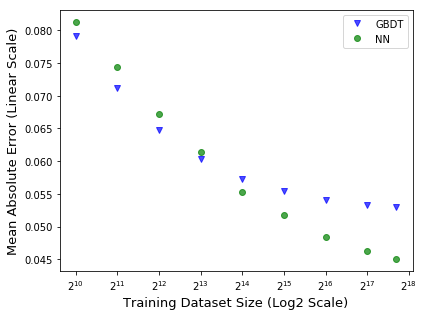

In [22]:
x = lgb['tr_size']
y = lgb['median']
ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, # yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=0.7,
                                   **plot_args, color='b', label='GBDT')
x = nn['tr_size']
y = nn['mean_absolute_error']
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, # yerr=yerr,
                                   ax=ax, ls='', marker='o', alpha=0.7,
                                   **plot_args, color='g', label='NN')

ax.legend(frameon=True, fontsize=10, loc='best')
plt.tight_layout()
ax.grid(False)

{'alpha': 1.6951677493590334, 'beta': -0.5888520332321645, 'gamma': 0.051713238990946764}
{'alpha': 0.5065706322318237, 'beta': -0.34390661400161615, 'gamma': 0.037511081914682096}


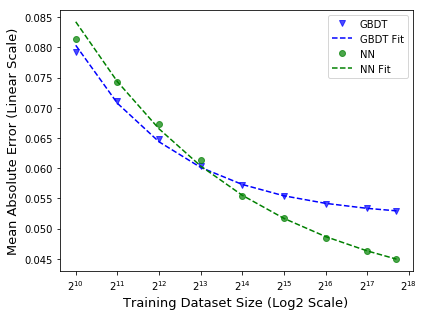

In [23]:
ax = None

x = lgb['tr_size']
y = lgb['median']

shard_min_idx = 0
xf = x[shard_min_idx:]
yf = y[shard_min_idx:]
prms_lgb = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms_lgb)

ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, # yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=0.7,
                                   **plot_args, color='b', label='GBDT')

ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=1,
                                   **plot_args, color='b', label='GBDT Fit')

x = nn['tr_size']
# y = nn['median']
y = nn['mean_absolute_error']

shard_min_idx = 0
xf = x[shard_min_idx:]
yf = y[shard_min_idx:]
prms_nn = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms_nn)

ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, # yerr=yerr,
                                   ax=ax, ls='', marker='o', alpha=0.7,
                                   **plot_args, color='g', label='NN')

ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=1,
                                   **plot_args, color='g', label='NN Fit')

ax.legend(frameon=True, fontsize=10, loc='best');
plt.tight_layout()
# ax.set_xlim([2**2, 2**17])
# ax.set_ylim([2**-4, 2**-2])
# ax.set_xlim([2**2, 2**17])
# ax.set_ylim([0.055, 0.165])
# ax.set_ylim([0.065, 0.165])
ax.grid(False)
# ax.set_xticks([2**i for i in range(2, 17)]) # GDSC
# ax.set_xticks([2**i for i in range(2, 19)]) # Top6
# save_fig(save_fig_path, fname='gbdt_vs_nn_on_top6')

print(prms_lgb)
print(prms_nn)

# Same model (GBDT); different dataset

In [21]:
figsize = (6, 4.5)
metric_name = 'mean_absolute_error'
tr_set = 'te'

plot_args = {'metric_name': metric_name, 'xtick_scale': 'log2', 'ytick_scale': 'linear', 'figsize': figsize}

In [22]:
# The previous two figures should help decide which shards to use
lgb_shift_idx = 0
# lgb_shift_idx = 9
lgb_gdsc_ = lgb_gdsc[lgb_shift_idx:].reset_index(drop=True)

# The previous two figures should help decide which shards to use
lgb_shift_idx = 0
# lgb_shift_idx = 9
lgb_top6_ = lgb_top6[lgb_shift_idx:].reset_index(drop=True)

# # nn_shift_idx = 0
# # nn_shift_idx = 2
# nn_shift_idx = 3
# nn = nn_top6[nn_shift_idx:].reset_index(drop=True)

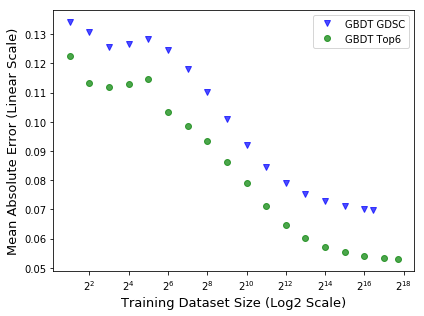

In [23]:
x = lgb_gdsc_['tr_size']
y = lgb_gdsc_['median']
ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, # yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=0.7,
                                   **plot_args, color='b', label='GBDT GDSC')
x = lgb_top6_['tr_size']
y = lgb_top6_['median']
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, # yerr=yerr,
                                   ax=ax, ls='', marker='o', alpha=0.7,
                                   **plot_args, color='g', label='GBDT Top6')

ax.legend(frameon=True, fontsize=10, loc='best')
plt.tight_layout()
ax.grid(False)

{'alpha': 1.170658331169888, 'beta': -0.556962177956805, 'gamma': 0.06761965078084098}
{'alpha': 1.6951677493590334, 'beta': -0.5888520332321645, 'gamma': 0.051713238990946764}


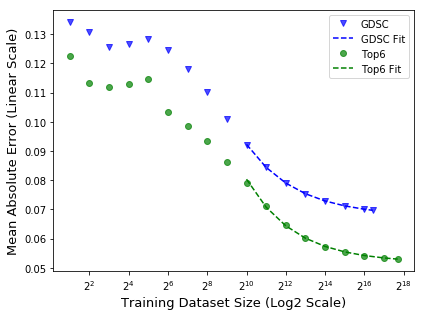

In [45]:
ax = None

x = lgb_gdsc_['tr_size']
y = lgb_gdsc_['median']

shard_min_idx = 9
xf = x[shard_min_idx:]
yf = y[shard_min_idx:]
prms_gdsc = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms_gdsc)

ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, # yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=0.7,
                                   **plot_args, color='b', label='GDSC')

ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=1,
                                   **plot_args, color='b', label='GDSC Fit')

x = lgb_top6_['tr_size']
y = lgb_top6_['median']
# y = lgb_top6_['mean_absolute_error']

shard_min_idx = 9
xf = x[shard_min_idx:]
yf = y[shard_min_idx:]
prms_top6 = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms_top6)

ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, # yerr=yerr,
                                   ax=ax, ls='', marker='o', alpha=0.7,
                                   **plot_args, color='g', label='Top6')

ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=1,
                                   **plot_args, color='g', label='Top6 Fit')

ax.legend(frameon=True, fontsize=10, loc='best');
plt.tight_layout()
# ax.set_xlim([2**2, 2**17])
# ax.set_ylim([2**-4, 2**-2])
# ax.set_xlim([2**2, 2**17])
# ax.set_ylim([0.055, 0.165])
# ax.set_ylim([0.065, 0.165])
ax.grid(False)
# ax.set_xticks([2**i for i in range(2, 17)]) # GDSC
# ax.set_xticks([2**i for i in range(2, 19)]) # Top6
# save_fig(save_fig_path, fname=f'{src}_avg_median_std')

print(prms_gdsc)
print(prms_top6)

# Same model (NN) --> but this is not the same model!! ; different dataset

In [31]:
figsize = (6, 4.5)
metric_name = 'mean_absolute_error'
tr_set = 'te'

plot_args = {'metric_name': metric_name, 'xtick_scale': 'log2', 'ytick_scale': 'linear', 'figsize': figsize}

In [40]:
# The previous two figures should help decide which shards to use
nn_shift_idx = 0
nn_shift_idx = 1
nn_gdsc_ = nn_gdsc[nn_shift_idx:].reset_index(drop=True)

# The previous two figures should help decide which shards to use
nn_shift_idx = 0
nn_shift_idx = 1
nn_top6_ = nn_top6[nn_shift_idx:].reset_index(drop=True)

# # nn_shift_idx = 0
# # nn_shift_idx = 2
# nn_shift_idx = 3
# nn = nn_top6[nn_shift_idx:].reset_index(drop=True)

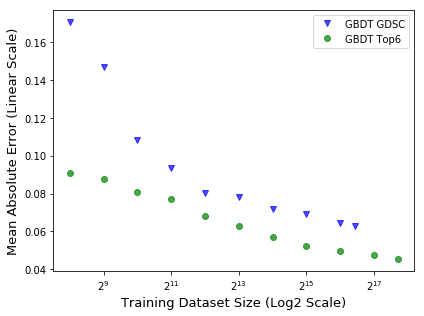

In [41]:
x = nn_gdsc_['tr_size']
y = nn_gdsc_['mean_absolute_error']
ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, # yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=0.7,
                                   **plot_args, color='b', label='Top6 GDSC')
x = nn_top6_['tr_size']
y = nn_top6_['mean_absolute_error']
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, # yerr=yerr,
                                   ax=ax, ls='', marker='o', alpha=0.7,
                                   **plot_args, color='g', label='Top6 Top6')

ax.legend(frameon=True, fontsize=10, loc='best')
plt.tight_layout()
ax.grid(False)

{'alpha': 0.20155540618554058, 'beta': -0.16868644371993824, 'gamma': 0.0335331576264325}
{'alpha': 0.38995411214936887, 'beta': -0.2964184127453158, 'gamma': 0.03525887549974903}


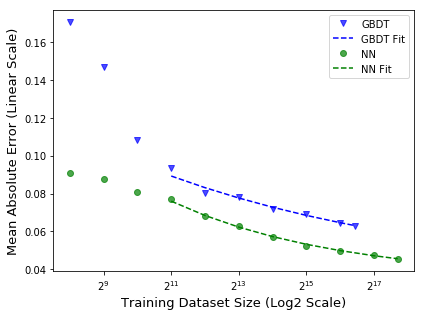

In [43]:
ax = None

x = nn_gdsc_['tr_size']
# y = nn_gdsc_['median']
y = nn_gdsc_['mean_absolute_error']

shard_min_idx = 3
xf = x[shard_min_idx:]
yf = y[shard_min_idx:]
prms_gdsc = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms_gdsc)

ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, # yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=0.7,
                                   **plot_args, color='b', label='GBDT')

ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=1,
                                   **plot_args, color='b', label='GBDT Fit')

x = nn_top6_['tr_size']
# y = nn_top6_['median']
y = nn_top6_['mean_absolute_error']

shard_min_idx = 3
xf = x[shard_min_idx:]
yf = y[shard_min_idx:]
prms_top6 = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms_top6)

ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, # yerr=yerr,
                                   ax=ax, ls='', marker='o', alpha=0.7,
                                   **plot_args, color='g', label='NN')

ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=1,
                                   **plot_args, color='g', label='NN Fit')

ax.legend(frameon=True, fontsize=10, loc='best');
plt.tight_layout()
# ax.set_xlim([2**2, 2**17])
# ax.set_ylim([2**-4, 2**-2])
# ax.set_xlim([2**2, 2**17])
# ax.set_ylim([0.055, 0.165])
# ax.set_ylim([0.065, 0.165])
ax.grid(False)
# ax.set_xticks([2**i for i in range(2, 17)]) # GDSC
# ax.set_xticks([2**i for i in range(2, 19)]) # Top6
# save_fig(save_fig_path, fname=f'{src}_avg_median_std')

print(prms_gdsc)
print(prms_top6)